In [0]:
!pip install gtsam

     |████████████████████████████████| 7.8MB 2.6MB/s 


In [0]:
from __future__ import print_function

import math
import unittest
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import linalg, matrix

import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import mpl_toolkits.mplot3d.axes3d as p3

# Required to do animations in colab
from matplotlib import animation
from IPython.display import HTML
from mobileManipulator import FourLinkMM
import gtsam
import gtsam.utils.plot as gtsam_plot
from gtsam import Pose2
import shapely
from shapely.geometry import Polygon, LineString
from shapely import affinity
from utils import *

In [0]:
def visualize_tree(env, graph, graph_dictionary, goal, start):
    plt.figure()
    for edge in graph.edges:
        parent_idx, child_idx = edge
        end_eff_p = graph_dictionary[parent_idx]
        end_eff_c = graph_dictionary[child_idx]
        plt.plot([end_eff_p.x(), end_eff_c.x()], [end_eff_p.y(), end_eff_c.y()], "ro-", markersize=2)
    for obstacle in env.obstacles:
        plt.plot(*obstacle.exterior.xy)
    plt.plot(start.x(), start.y(), marker="o", color ="g", markersize=9)
    plt.plot(goal.x(), goal.y(), marker="o", color = "b", markersize=9)
    plt.show()

In [0]:
def plot_environment(arm, env, goal):
    base, link_1, link_2, link_3, link_4 = arm.create_manipulator_model(Pose2(0, 0, 0), vector4(0, 0, 0, 0))
    plt.figure()
    plt.plot(*base.exterior.xy)
    plt.plot(*link_1.exterior.xy)
    plt.plot(*link_2.exterior.xy)
    plt.plot(*link_3.exterior.xy)
    plt.plot(*link_4.exterior.xy)
    for obstacle in env.obstacles:
        plt.plot(*obstacle.exterior.xy)
    plt.plot(goal.x(), goal.y(), marker="o", color="b", markersize=9)
    plt.show()

# **Setup Environment with obstacles**

In [0]:
# from rrt_star_manipulator import * 

max_x = 60
max_y = 60
QStart = Pose2(10, 0, 0)
start_config = (Pose2(0, 0, 0), vector4(0, 0, 0, 0), QStart)
arm = FourLinkMM()

In [0]:
import numpy as np
import sklearn
import networkx as nx
from matplotlib import pyplot as plt
import shapely
from shapely.geometry import Polygon, Point
import sys
from mobileManipulator import FourLinkMM
import gtsam
import gtsam.utils.plot as gtsam_plot
from gtsam import Pose2
from utils import *
import math
from operator import itemgetter
sys.setrecursionlimit(10**6)

# np.random.seed(42)

max_x = 50
max_y = 50

c_map = np.zeros((max_x, max_y))
no_obstacles = 5
o_size = 4


def RandomQ(Qgoal, arm, env):
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    sTt_b = None
    end_effector = None
    q = vector4(0, 0, 0, 0)
    if np.random.random_sample() <= 0.20: #15% probability that it returns Qgoal
        # sTt_b, q = arm.ik2(Qgoal, env.obstacles)
        # return sTt_b, q, Qgoal
        return Qgoal
    collision = True
    while collision:
        x = np.random.random_sample()*env.max_x
        y = np.random.random_sample()*env.max_y
        theta = np.random.random_sample()*360 - 180
        end_effector = Pose2(x, y, math.radians(theta))
        if env.check_collision_with_obstacles(end_effector) == False:
            break
            # sTt_b, q = arm.ik2(end_effector, env.obstacles)
            # collision = arm.check_collision_with_obstacles(env.obstacles, sTt_b, q)
        else:
            collision = True

    return end_effector
    # return sTt_b, q end_effector

class Environment:
    def __init__(self, max_x, max_y, obstacles=None, num_obstacles=5, obstacle_size=4):
        self.max_x = max_x
        self.max_y = max_y
        self.c_map = np.zeros((max_x, max_y))
        self.num_obstacles = num_obstacles
        self.o_size = obstacle_size
        if obstacles is None:
            self.obstacles = self.create_obstacles()
        else:
            self.obstacles = obstacles

    def create_obstacles(self):
        obstacles = []
        i = 0
        while i < no_obstacles:
          ob_pos_x, ob_pos_y = self.randomPosition()
          obstacle = shapely.geometry.box(ob_pos_x, ob_pos_y,
                    ob_pos_x + self.o_size, ob_pos_y + self.o_size)
          obstacles.append(obstacle)
          i += 1
        return obstacles
    def check_collision_with_obstacles(self, pose):

        point = Point(pose.x(), pose.y())
        for obstacle in self.obstacles:
            if obstacle.contains(point) or obstacle.exterior.distance(point) <= 2.5:
                return True
        return False

    def check_obstacle_free(self, pose1, pose2):
        """
        Checks if two poses have an obstacle free straight line path
        """
        line = LineString([(pose1.x(), pose1.y()), (pose2.x(), pose2.y())])
        for obstacle in self.obstacles:
            if obstacle.intersects(line) or obstacle.crosses(line) or obstacle.touches(line) or obstacle.distance(line) <= 1:
                return False
        return True

    def randomPosition(self):
        xc = np.random.randint(self.max_x)
        yc = np.random.randint(self.max_y)
        return xc, yc

class Node_manip():
    def __init__(self, idx, end_effector_pose, dictionary, G):
        self.idx = idx
        self.cost = 0
        # self.q = Q
        # self.base_pose = base_pose
        self.end_effector_pose = end_effector_pose
        self.neighbors = []
        self.parent = None
        dictionary[idx] = self.end_effector_pose
        G.add_node(idx)

class Tree_manip():
    def __init__(self, curr_iter, curr_node):
        self.root = curr_node
        self.costs = {}
        self.costs[self.root.idx] = self.root.cost
        self.nodes = {}
        #maps indicies to node objects
        self.nodes[self.root.idx] = self.root
        self.edges = []

    def find_dist(self, q0, q1):
        pose_1 = q0.end_effector_pose

        dist_val = np.linalg.norm(delta(q1, pose_1))
        return dist_val
      
    def find_dist2(self, pose_1, q1):
        dist_val = np.linalg.norm(delta(q1, pose_1))
        return dist_val

    def find_neighbors(self, q, dictionary, radius, G, env, min_cost = 10000000):
      costs = {}
      Xbest = None
      min_cost = 10000000
      index = -1
      for i in dictionary.keys():
        q0 = dictionary[i]
        c = self.find_dist2(q0, q)
        if env.check_obstacle_free(q0, q) and c <= radius:
          costs[i] = c
          if c < min_cost:
            Xbest = q0
            min_cost = c
            index = i
      return Xbest, costs, index
    def iterate(self, q, qc):

        if q== None or q.neighbors == []: #no neighbors
            return 10000, q

        m1 = 1000000
        e1 = None

        for i in range(len(q.neighbors)):
            new_dist = self.find_dist(q.neighbors[i], qc)

            if new_dist < m1:
                e1 = q.neighbors[i]
                m1 = new_dist

            #explore neighbor
            m2, e2 = self.iterate(e1, qc)
            if m2 < m1:
                m1 = m2
                e1 = e2

        return m1, e1

    def steer(self, Q_curr, end_eff_new, step_size, arm, env, distance_limit=2.5):
        end_eff_1 = Q_curr.end_effector_pose
        # base_1 = Q_curr.base_pose
        if env.check_collision_with_obstacles(end_eff_1):
            # return None, None, None
            return None
        # q1 = np.asarray(Q_curr)
        # q2 = np.asarray(Q_new) #go in direction of q2
        if np.linalg.norm(delta(end_eff_1, end_eff_new)) < distance_limit:
            # return base_new, q_new, end_eff_new
            return end_eff_new
        q_sub = delta(end_eff_1, end_eff_new)
        q_dir = q_sub/np.linalg.norm(q_sub)
        q_dir *= step_size

        q_new = vector3(end_eff_1.x(), end_eff_1.y(), end_eff_1.theta()) + q_dir
        end_eff_steer = Pose2(q_new[0], q_new[1], q_new[2])
        if env.check_collision_with_obstacles(end_eff_steer) == False and env.check_obstacle_free(end_eff_1, end_eff_steer) == True:
            # base_pose, q_steer = arm.ik2(end_eff_steer, env.obstacles)
            # return base_pose, q_steer, end_eff_steer
            return end_eff_steer
        else:
            # return None, None, None
            return None

    def steer2(self, end_eff_1, end_eff_new, step_size, arm, env, distance_limit=2.5):
        # base_1 = Q_curr.base_pose
        if env.check_collision_with_obstacles(end_eff_1):
            return None
        if np.linalg.norm(delta(end_eff_1, end_eff_new)) < distance_limit:
            return end_eff_new
        q_sub = delta(end_eff_1, end_eff_new)
        q_dir = q_sub/np.linalg.norm(q_sub)
        q_dir *= step_size

        q_new = vector3(end_eff_1.x(), end_eff_1.y(), end_eff_1.theta()) + q_dir
        end_eff_steer = Pose2(q_new[0], q_new[1], q_new[2])
        if env.check_collision_with_obstacles(end_eff_steer) == False and env.check_obstacle_free(end_eff_1, end_eff_steer) == True:
            return end_eff_steer
        else:
            # return None, None, None
            return None

    def link(self, q1, q2, G):
        if q2 not in q1.neighbors:
            q1.neighbors.append(q2)
            q2.parent = q1
            link_cost = self.find_dist2(q1.end_effector_pose, q2.end_effector_pose)
            q2.cost = link_cost + q1.cost
            G.add_edge(q1.idx, q2.idx)
            self.edges.append((q1.idx, q2.idx))
            self.costs[q2.idx] = q2.cost
            self.nodes[q2.idx] = q2
            return

    def find_closest(self, Q_curr):
        min_dist, explore = self.iterate(self.root, Q_curr)
        return explore

    def find_closest2(self, Q_curr):
        min_dist, explore = self.iterate(self.root, Q_curr)
        return explore, min_dist


def RRT(start_config, Qgoal, env, arm, lim=0.5, step_size=3, num_iters=1000):
    base, q, Qstart = start_config
    dictionary = {}
    curr_iter = 0
    # num_iters = 1000
    G = nx.Graph()
    # lim = 0.2 #The robot can stop at a configuration (q1,q2,q3,q4) where q[i] is at most 15 degrees away from Qgoal[i]
    # step_size = 3
    path = []
    root = Node_manip(0, Qstart, dictionary, G)
    path.append((base, q, Qstart))
    graph = Tree_manip(0, root)

    till_now = [root]
    curr_node = root
    converged = False

    while curr_iter < num_iters:

        if curr_iter % 1000 == 0:
            print("ITERATION: " + str(curr_iter))
        # sTt_b_rand, q_rand, end_eff_rand = RandomQ(Qgoal, arm, env)
        end_eff_rand = RandomQ(Qgoal, arm, env)
        #print('NEW ITERATION')

        nearest_node = graph.find_closest(end_eff_rand)
        #c1 = [nearest_node.t1, nearest_node.t2, nearest_node.t3, nearest_node.t4]


        end_eff_steer = graph.steer(nearest_node, end_eff_rand, step_size, arm, env, distance_limit=step_size)
        add_node = curr_node
        if end_eff_steer is not None:
            add_node = Node_manip(curr_iter, end_eff_steer, dictionary, G)
            graph.link(nearest_node, add_node, G)
            curr_node = add_node
            add = add_node.end_effector_pose
            curr_iter +=1
            if np.linalg.norm(delta(add, Qgoal)) <= lim:
                print('reached goal')
                converged = True
                break
        else:
            curr_iter += 1
    if not converged:
        print("Failed to converge")
    else:
        print("Iterations to converge: " + str(curr_iter))
    v_path = nx.algorithms.shortest_path(G, root.idx, add_node.idx)
    # print('Vertices for shortest path:',v_path)
    path_dist = 0
    prev_pose = None
    curr_pose = None
    for p in v_path:
        end_effector = dictionary[p]
        prev_pose = curr_pose
        curr_pose = end_effector
        if prev_pose is not None:
            dist = np.linalg.norm(delta(curr_pose, prev_pose))
            path_dist += dist
        # collision = True
        # sTt_b = None
        # q = None
        # sTt_b, q = arm.ik2(end_effector, env.obstacles)
        path.append(end_effector)
        # collision = arm.check_collision_with_obstacles(env.obstacles, sTt_b, q)
        # path.append((sTt_b, q, end_effector))
    # print('Actual path:',path)
    print('Path Distance: ' + str(path_dist))

    return path, dictionary, G, curr_iter, path_dist, converged

def get_base_and_joint_from_path(path, arm, env):
    total_path = []
    for pose in path:
      if type(pose) == tuple:
        total_path.append(pose)
      else:
        sTt_b, q = arm.ik2(pose, env.obstacles)
        total_path.append((sTt_b, q, pose))
    return total_path


def RRT_star(start_config, Qgoal, env, arm, lim=0.5, step_size=3, num_iters=1000):
    base, q, Qstart = start_config
    dictionary = {}
    curr_iter = 0
    # num_iters = 1000
    G = nx.Graph()
    # lim = 0.2 #The robot can stop at a configuration (q1,q2,q3,q4) where q[i] is at most 15 degrees away from Qgoal[i]
    # step_size = 3
    path = []
    root = Node_manip(0, Qstart, dictionary, G)
    path.append((base, q, Qstart))
    graph = Tree_manip(0, root)

    till_now = [root]
    curr_node = root
    converged = False
    radius = 30

    while curr_iter < num_iters:

        if curr_iter % 1000 == 0:
            print("ITERATION: " + str(curr_iter))
        # sTt_b_rand, q_rand, end_eff_rand = RandomQ(Qgoal, arm, env)
        end_eff_rand = RandomQ(Qgoal, arm, env)
        #print('NEW ITERATION')

        nearest_node, min_dist = graph.find_closest2(end_eff_rand)

        # sTt_b_steer, q_steer, end_eff_steer = graph.steer(nearest_node, end_eff_rand,
        #                                                 q_rand, sTt_b_rand, step_size, arm, env,
        #                                                 distance_limit=step_size)

        Xbest, costs, index = graph.find_neighbors(end_eff_rand, dictionary, radius, G, env)

        if Xbest == None: #No node found in that radius
          Xbest = nearest_node
          steer_node = graph.steer(Xbest, end_eff_rand, step_size, arm, env, distance_limit=step_size)
        else:
        #print('works')
          Xbest = graph.nodes[index]
          steer_node = graph.steer2(Xbest.end_effector_pose, end_eff_rand, step_size, arm, env, distance_limit=step_size)

        #end_eff_steer = graph.steer(nearest_node, end_eff_rand, step_size, arm, env, distance_limit=step_size)
        add_node = curr_node
        end_eff_steer = steer_node


        if end_eff_steer is not None:
            add_node = Node_manip(curr_iter, end_eff_steer, dictionary, G)
            graph.link(Xbest, add_node, G)
            steer_node_cost = graph.costs[curr_iter]
            curr_node = add_node
            add = add_node.end_effector_pose
            curr_iter +=1
            if np.linalg.norm(delta(add, Qgoal)) <= lim:
                print('reached goal')
                converged = True
                break

            for idx in costs:
                qn = dictionary[idx]
                if steer_node_cost + graph.find_dist2(qn, end_eff_steer) < graph.costs[idx] and env.check_obstacle_free(qn, end_eff_steer):
                    print("rewire")
                    # curr_iter += 1
                    graph.costs[idx] = steer_node_cost + graph.find_dist2(qn, end_eff_steer)
                    qn_node = graph.nodes[idx]
                    parent_idx = qn_node.parent.idx
                    # new_steer_node = graph.steer2(qn, end_eff_rand, step_size)
                    # new_add_node = Node_manip(curr_iter, new_steer_node, dictionary, G)
                    if env.check_obstacle_free(qn, end_eff_steer):
                      if (parent_idx, idx) in G.edges and parent_idx != root.idx:
                        G.remove_edge(parent_idx, idx)
                      graph.link(add_node, qn_node, G)
        else:
            curr_iter += 1
    if not converged:
        print("Failed to converge")
    else:
        print("Iterations to converge: " + str(curr_iter))
    v_path = nx.algorithms.shortest_path(G, root.idx, add_node.idx)
    # print('Vertices for shortest path:',v_path)
    path_dist = 0
    prev_pose = None
    curr_pose = None
    for p in v_path:
        end_effector = dictionary[p]
        prev_pose = curr_pose
        curr_pose = end_effector
        if prev_pose is not None:
            dist = np.linalg.norm(delta(curr_pose, prev_pose))
            path_dist += dist
        # collision = True
        # sTt_b = None
        # q = None
        # sTt_b, q = arm.ik2(end_effector, env.obstacles)
        path.append(end_effector)
        # collision = arm.check_collision_with_obstacles(env.obstacles, sTt_b, q)
        # path.append((sTt_b, q, end_effector))
    # print('Actual path:',path)
    print('Path Distance: ' + str(path_dist))

    return path, dictionary, G, curr_iter, path_dist, converged



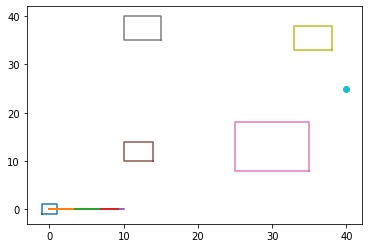

In [219]:
obstacles = [shapely.geometry.box(10, 10, 14, 14), shapely.geometry.box(25, 8, 35, 18), shapely.geometry.box(10, 35, 15, 40), shapely.geometry.box(33, 33, 38,38)]
env = Environment(max_x, max_y, obstacles=obstacles)
QGoal = Pose2(40, 25, np.pi/2)
plot_environment(arm, env, QGoal)

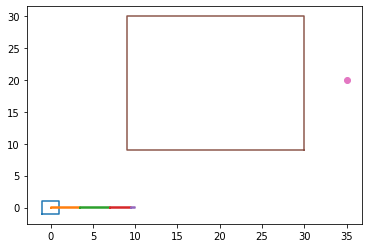

In [242]:
obstacles1 = [shapely.geometry.box(9, 9, 30, 30)]
QGoal = Pose2(35, 20, 0)
env = Environment(max_x, max_y, obstacles=obstacles1)
plot_environment(arm, env, QGoal)


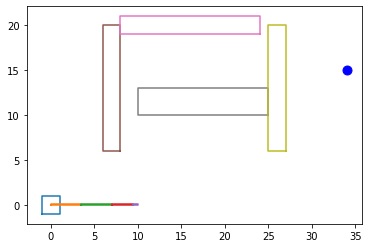

In [272]:
QGoal = Pose2(34, 15, np.pi)
obstacles2 = [shapely.geometry.box(6, 6, 8, 20), shapely.geometry.box(8, 19, 24, 21), shapely.geometry.box(10, 10, 25, 13), shapely.geometry.box(25, 6, 27, 20)]
env = Environment(max_x, max_y, obstacles=obstacles2, num_obstacles=7, obstacle_size = 8)
plot_environment(arm, env, QGoal)



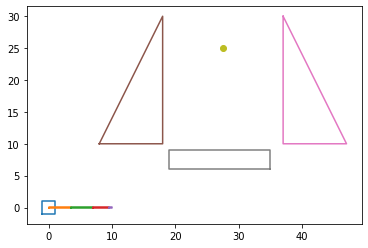

In [239]:
QGoal = Pose2(27.5, 25, 0)
obstacles3 = [Polygon([(8, 10), (18, 10), (18, 30)]), Polygon([(37, 30), (37, 10), (47, 10)]), shapely.geometry.box(19, 6, 35, 9)]
env = Environment(max_x, max_y, obstacles=obstacles3)
plot_environment(arm, env, QGoal)

In [273]:
path, graph_dictionary, graph, iterations, path_dist, converged = RRT_star(start_config, QGoal, env, arm, lim=0.5, step_size=1.5, num_iters=10000)

ITERATION: 0
rewire
rewire
rewire
rewire
rewire
rewire
rewire
rewire
rewire
rewire
rewire
reached goal
Iterations to converge: 239
Path Distance: 35.97666406301207


In [0]:
path = get_base_and_joint_from_path(path, arm, env)

# **Tree Visualization**

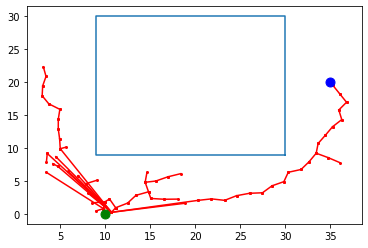

In [261]:
visualize_tree(env, graph, graph_dictionary, QGoal, QStart)

In [263]:
end_effector_path_x = []
end_effector_path_y = []
for node in path:
    end_effector_path_x.append(node[2].x())
    end_effector_path_y.append(node[2].y())
fig = plt.figure()
fig.set_dpi(100)
ax = plt.axes(xlim=(-5, max_x), ylim=(-5, max_y))
plt.rc('animation', html='jshtml') # needed for animations!
#ax = plt.axes()
plt.close()
N = len(path)
# size=10.5
len_b = 2
d = np.sqrt(2*len_b*len_b/4)
omega = 2*math.pi/N
# arm = FourLinkMM()
# arm.x_b = 0
# arm.y_b = 0
# arm.theta_b = 0
q = np.radians(vector4(90,30,45,0))
sTt_initial = arm.fwd_kinematics(q)
print(sTt_initial)
print(q)
# ax.legend()

(44.1042, 22.4517, 2.129)

[1.57079633 0.52359878 0.78539816 0.        ]


In [0]:
def init():

  # For animation
    rect = mpatches.Rectangle([arm.x_b-d*np.cos(arm.theta_b+np.radians(45)),arm.y_b-d*np.sin(arm.theta_b+np.radians(45))], len_b, len_b, angle = arm.theta_b*180/np.pi)
    ax.plot(QGoal.x(), QGoal.y(), marker="o", markersize=8)
    #     ax.add_patch(rect)
#     ax.add_patch(link_1)
#     ax.add_patch(link_2)
#     ax.add_patch(link_3)
#     ax.add_patch(link_4)
#     ax.add_patch(mpatches.FancyArrow(arm.x_b,arm.y_b, 1.5*np.cos(arm.theta_b), 1.5*np.sin(arm.theta_b), color='r',head_width = 0.3))

    return rect,


def animate(i):

    global path
    global end_effector_path_x
    global end_effector_path_y
    global arm
    global q
    global prev_pose
    global curr_pose
    global env
    # Computes the forward kinematics to get the pose of the end-effector for the given angular position of the joints (q)
    base, q, end_effector = path[i]
    #     base, q = arm.ik2(poses[i])
    arm.update_manipulator_model(base, q)
    sTt = arm.fwd_kinematics(q)

    # Get the jacobian of the arm at the given pose
    # ------------------------- ANIMATION ----------------------------------------------------
    rect = mpatches.Rectangle([arm.x_b-d*np.cos(arm.theta_b+np.radians(45)),arm.y_b-d*np.sin(arm.theta_b+np.radians(45))],
                    len_b, len_b, angle = arm.theta_b*180/np.pi, color = 'b')
    #ax.clear()
    ax.clear()
    for obstacle in env.obstacles:
        ax.plot(*obstacle.exterior.xy)
    ax.plot(end_effector_path_x, end_effector_path_y, "ro-", markersize=2)
#     if prev_pose is None:
#         obj = ax.plot(curr_pose.x(), curr_pose.y(), marker="o", markersize=3)
#     #         ax.add_artist(obj)
#         prev_pose = curr_pose
#         curr_pose = poses[i + 1]
#     else:
#         obj = ax.plot([prev_pose.x(), curr_pose.x()], [prev_pose.y(), curr_pose.y()], "ro-", markersize=3)
#     #         ax.add_artist(obj)
#         prev_pose = curr_pose
#     if i + 1 < len(poses):
#         curr_pose = poses[i + 1]
    ax.add_patch(rect)
    
    #link 1
    sXl1 = Pose2(0, 0, arm.theta_b)
    l1Zl1 = Pose2(0, 0, q[0])
    l1Xl2 = Pose2(arm.L1, 0, 0)
    sTl2 = compose(sXl1, l1Zl1, l1Xl2)
    t1 = sTl2.translation()

    #link 2
    l2Zl2 = Pose2(0, 0, q[1])
    l2Xl3 = Pose2(arm.L2, 0, 0)
    sTl3 = compose(sTl2, l2Zl2, l2Xl3)
    t2 = sTl3.translation()

    #link 3
    l3Zl3 = Pose2(0, 0, q[2])
    l3X4 = Pose2(arm.L3, 0, 0)
    sTl4 = compose(sTl3, l3Zl3, l3X4)
    t3 = sTl4.translation()

    #link 4
    l4Zl4 = Pose2(0, 0, q[3])
    l4Xt = Pose2(arm.L4, 0, 0)
    sTt = compose(sTl4, l4Zl4, l4Xt)
    t4 = sTt.translation()
    
    #link 1
#     sXl1 = Pose2(0, 0, arm.theta_b)
#     l1Zl1 = Pose2(0, 0, q[0])
#     l1Xl2 = Pose2(arm.L1, 0, 0)
#     sTl2 = compose(sXl1, l1Zl1, l1Xl2)
#     t1 = sTl2.translation()
    ax.add_artist(mpatches.Rectangle([arm.x_b,arm.y_b], 3.5, 0.1, angle =np.rad2deg(arm.theta_b+q[0]), color='r'))
    
    #link2
#     l2Xl3 = Pose2(arm.L2, 0, 0)
#     sTl3 = compose(sTl2, l2Zl2, l2Xl3)
#     t2 = sTl3.translation()
    ax.add_artist(mpatches.Rectangle([t1.x()+arm.x_b,t1.y()+arm.y_b], 3.5, 0.1, angle =np.rad2deg(arm.theta_b+q[0]+q[1]), color='g'))

    #link3
#     l3Zl3 = Pose2(0, 0, q[2])
#     l3X4 = Pose2(arm.L3, 0, 0)
#     sTl4 = compose(sTl3, l3Zl3, l3X4)
#     t3 = sTl4.translation()
    ax.add_artist(mpatches.Rectangle([t2.x()+arm.x_b,t2.y()+arm.y_b], 2.5, 0.1, angle = np.rad2deg(arm.theta_b+q[0]+q[1]+q[2]), color='b'))

    #link4
#     l4Zl4 = Pose2(0, 0, q[3])
#     l4Xt = Pose2(arm.L4, 0, 0)
#     sTt = compose(sTl4, l4Zl4, l4Xt)
#     t4 = sTt.translation()
    ax.add_artist(mpatches.Rectangle([t3.x()+arm.x_b,t3.y()+arm.y_b], 0.5, 0.1, angle =np.rad2deg(arm.theta_b+q[0]+q[1]+q[2]+q[3]), color='k'))


    return rect,

# **Animation**

In [265]:
animation.FuncAnimation(fig, animate, init_func=init,
                        frames=N, interval=500, blit=False)

In [0]:
ani = animation.FuncAnimation(fig, animate, init_func=init,
                        frames=N, interval=500, blit=False)

# plt.show()


In [0]:
ani.save('rrt_star_animation_env2.mp4', writer='ffmpeg', fps=2)